# Cleaning: Futurama

In this notebook we clean the audio files that we have already trimmed into approximately 5 second intervals in exactly the same way as the training data.

Please note that as this notebook will be uploaded to Github, and as the audio files include copyrighted audio we are not able to upload and distribute the files that are used in this notebook as it would potentially open us up to legal liability for distribution of copyrighted materials. This notebook is provided only for demonstration purposes.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display
import scipy

Dataset explored is UrbanSound8K:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

https://urbansounddataset.weebly.com/urbansound8k.html

https://zenodo.org/record/1203745

In [30]:
# Function to load wav file with librosa, given an index value corresponding to the audio section of the futurama
# episode.
def load_data(index,sr):
    fileprefix = 'futuramaErdos-'
    filesuffix = '.wav'
    fileindex = str(index)
    fileindex = fileindex.zfill(2)
    filepath = f'large_data/FuturamaValidation5s/'
    return librosa.load(filepath+fileprefix+fileindex+filesuffix,sr=sr)

The various audiofiles do not exhibit a uniform length or sampling rate. As such we aim to do some pre-classification analysis to generate a uniform observable vector.

For this reason we are going to take inspiration from the idea of a music "equalizer" scale. We will break down the fourier transform of each audio section into a number of human audible frequencies, as well as the sub-audible and supra-audible sections. 

In [6]:
row_ind = 10
test_y, sr = load_data(row_ind)

In [7]:
IPython.display.Audio(test_y / test_y.max(),rate=sr)

In [8]:
librosa.get_duration(y=test_y,sr=sr)

5.161043083900227

In [9]:
len(test_y)

t = np.round(librosa.get_duration(y=test_y,sr=sr),3)
dt = t/len(test_y)
print(dt)

k = np.fft.fftfreq(len(test_y), d=dt)
print(k[1])

yk = np.fft.fft(test_y)
mag_yk = np.abs(yk)
mag_yk = mag_yk[:len(mag_yk)//2]

test_y2 = np.sqrt(test_y*test_y)
yk2 = np.fft.fft(test_y2)
mag_yk2 = np.abs(yk2)
mag_yk2 = mag_yk2[:len(mag_yk2)//2]

filttest = yk * np.exp(-k*k/10000000)
test_back = np.fft.ifft(filttest)

test_y.max()

np.sqrt(test_y2.mean())

Crestfactor = test_y.max()/np.sqrt(test_y2.mean())
Crestfactor

2.2675547666540714e-05
0.19376089905057162


1.7763529

After initial exploration of the data I noticed that a number of the audio samples have significant "room noise" present. In an attempt to clean this up I'm taking the hilbert transform (extracts the instantaneous amplitude of a signal). Smoothing this transform and dividing by the root mean square power should then amplify the parts of the signal that are large in amplitude, while minimizing the areas that are simply a constant amplitude "hum". Low crest factor systems will be largely unaffected as the amplitude will be similar to the root mean square of the signal for such signals. Finally we ensure that the maximum amplitude of the signal is scaled to be equal to the input signal.

In [10]:
# unfiltered hilbert scaling
testwav = test_y * np.abs(np.abs(scipy.signal.hilbert(test_y)))/np.sqrt((test_y*test_y).mean())
testwav *= test_y.max() / testwav.max()

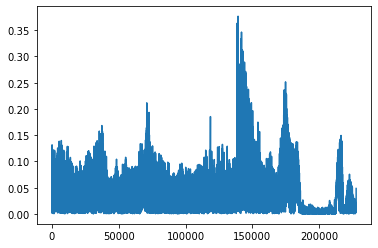

In [11]:
hil = np.abs(scipy.signal.hilbert(test_y))
plt.plot(hil)

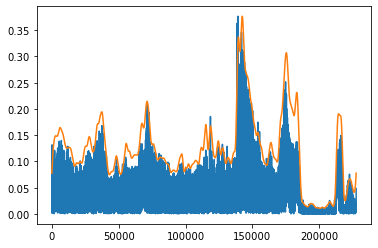

In [12]:
hilk = np.fft.fft(hil)
hilk *= np.exp(-k*k / (2*10**2))
hil2 = np.fft.ifft(hilk)
hil2 = np.abs(hil2)
hil2 *= hil.max() / hil2.max()
plt.plot(hil)
plt.plot(np.abs(hil2))

In [13]:
# filtered hilbert scaling
testwav2 = test_y * hil2/np.sqrt((test_y*test_y).mean())
testwav2 *= test_y.max() / testwav2.max()

In [15]:
IPython.display.Audio(test_y / test_y.max(),rate=sr)

Check the audio samples against one another to see if our attempts at minimizing room noise were successful.

In [23]:
IPython.display.Audio(testwav / testwav.max() * test_y.max(),rate=sr)

In [24]:
IPython.display.Audio(testwav2 / testwav2.max() * test_y.max(),rate=sr)

Note that the version with the filtered hilbert transform acting as the instantaneous amplitude has less distortion.

We now generate the equilizer values by manually summing over the relevent portions of fourier space.

In [25]:
eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
equilizer = np.zeros(12)
equilizer2 = np.zeros(12)
equilizer3 = np.zeros(12)
# equilizer4 = np.zeros(12)

ykclean = np.fft.fft(testwav)
mag_ykclean = np.abs(ykclean)
mag_ykclean = mag_ykclean[:len(mag_ykclean)//2]

ykclean2 = np.fft.fft(testwav2)
mag_ykclean2 = np.abs(ykclean2)
mag_ykclean2 = mag_ykclean2[:len(mag_ykclean2)//2]

# ykclean3 = np.fft.fft(testwav3)
# mag_ykclean3 = np.abs(ykclean3)
# mag_ykclean3 = mag_ykclean3[:len(mag_ykclean3)//2]

index = 0
for i in range(0,12):
    num = 0
    while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
        equilizer[i] += mag_yk[index]
        equilizer2[i] += mag_ykclean[index]
        equilizer3[i] += mag_ykclean2[index]
#         equilizer4[i] += mag_ykclean3[index]
        index += 1
        num += 1
    equilizer[i] /= num
    equilizer2[i] /= num
    equilizer3[i] /= num
#     equilizer4[i] /= num
    
equilizer /= equilizer.max()
equilizer2 /= equilizer2.max()
equilizer3 /= equilizer3.max()
# equilizer4 /= equilizer4.max()

In [14]:
print(equilizer)
print(equilizer2)
print(equilizer3)

[0.7346875  1.         0.7766004  0.53614021 0.37440668 0.32556507
 0.23651321 0.13944434 0.08363195 0.04882461 0.0251458  0.02284873]
[0.64105894 1.         0.80952242 0.59104958 0.44453732 0.38825493
 0.28387851 0.16895286 0.10413631 0.0619349  0.03204841 0.02912976]
[0.69964721 1.         0.74162181 0.50426083 0.34569131 0.28882308
 0.20580009 0.12123321 0.07385924 0.04345445 0.02242813 0.02038173]


Sanity check with some plots. We notice that the unfiltered version of our clean up step displays distortion in the numerical data as well as testing by ear.

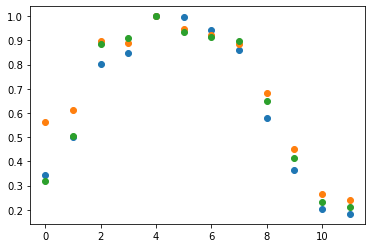

In [26]:
plt.scatter(range(0,12),equilizer)
plt.scatter(range(0,12),equilizer2)
plt.scatter(range(0,12),equilizer3)

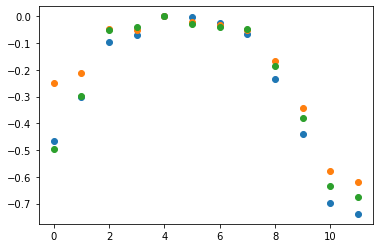

In [27]:
plt.scatter(range(0,12),np.log(equilizer)/np.log(10.0))
plt.scatter(range(0,12),np.log(equilizer2)/np.log(10.0))
plt.scatter(range(0,12),np.log(equilizer3)/np.log(10.0))

We have been iterating through feature selection, and fitting, and examination of the confusion matrix shows that
1. The classifier stuggles to differentiate between music and other types of data.
2. Gun shots and children playing are often paired in the confusion matrix.

We expect that children playing should be a much more "musical" type of sound than gun shots. For these two reasons we are going to try and extract some music based features.

Librosa has a function to decompose the harmonic and percussive components of a spectrogram. This seems to be done by checking for peaks in the fourier domain (harmonic) and time domain (percussive).

In [28]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)

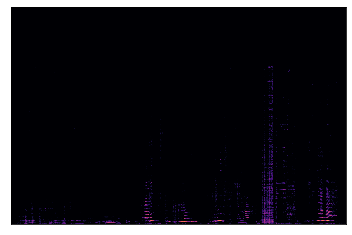

In [29]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_harmonic),ref=np.max))

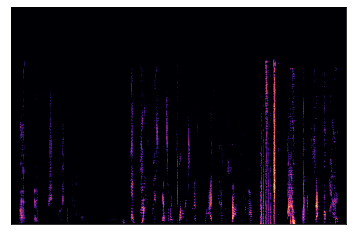

In [30]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_percussive),ref=np.max))

The decomposition loses a certain amount of power based on the 'margin' command which essentially sets how harsh the decomposition should be. For this reason we are going to rescale the power such that the sum of the two components still holds the same level of total power.

0.9999999999999999 0.9863684047385817 0.013631595261417894 0.9999999999999996


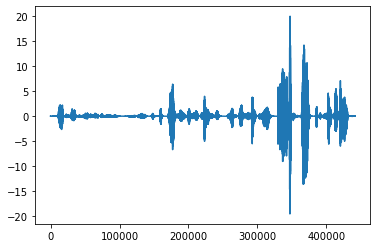

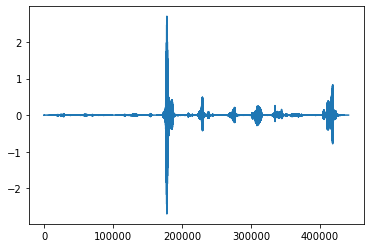

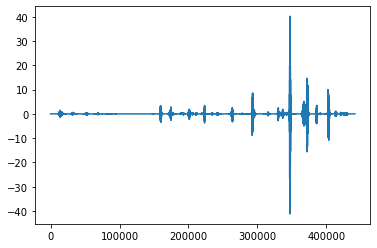

<Figure size 432x288 with 0 Axes>

In [31]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
y_p = librosa.istft(y_percussive, length=len(testwav2))
y_h = librosa.istft(y_harmonic, length=len(testwav2))
Ptot = (testwav2**2).mean()
ynorm = testwav2 / np.sqrt(Ptot)
Pnorm = (ynorm**2).mean()
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()
Anorm = np.sqrt(Pnorm/(P_h+P_p))
y_p *= Anorm
y_h *= Anorm
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()

print(Pnorm, P_p, P_h, (P_h + P_p))
plt.figure()
plt.plot(ynorm)
plt.figure()
plt.plot(y_h)
plt.figure()
plt.plot(y_p)
plt.figure()

y_percussive = librosa.stft(y_p)
y_harmonic = librosa.stft(y_h)

From the harmonic component we are going to generate a measure of the harmonics within the sound wave. A great deal of music is made up of chords from major thirds, minor thirds, major fifths, and a triplet consisting of a base frequency with its major third and major fifth.

The first thing we are going to do is extract the mean power in the various frequencies corresponding to different MIDI keys. A major third is then a pair consisting of a base frequency (MIDI $n$) and the key whose central frequency is closest to $3 f_n /2$. In a MIDI keyboard this then is the pair (MIDI $n$)+(MIDI $n+4$). Similarly minor thirds are (MIDI $n$)+(MIDI $n+3$), and major fifths are (MIDI $n$)+(MIDI $n+7$).

67


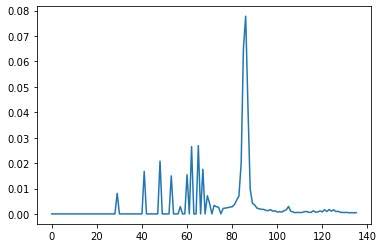

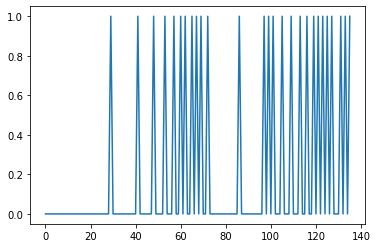

In [34]:
st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
fbins = []
keypitch = []
midi = []
maxlen=np.size(y_harmonic,0)
p = -69
kmin = 440*2**((p - 0.5)/12)
kmax = 440*2**((p+0.5)/12)
while kmax <= 20000:
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0])) != 0) :
        sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]))
    else:
        sumbin = 0
    fbins.append(sumbin)
    keypitch.append(440*2**(p/12))
    midi.append(p+69)
    p += 1
print(p)
plt.figure()
plt.plot(midi, fbins)
len(librosa.util.peak_pick(np.asarray(fbins), pre_max=1, post_max=1, pre_avg=1, post_avg=1, delta=0, wait=0))
peaks = librosa.util.localmax(np.asarray(fbins))
plt.figure()
plt.plot(np.asarray(peaks))

there are  1  major third(s),  1  minor third(s),  5  major third(s), and  2  major chord(s).


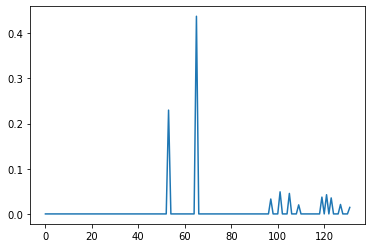

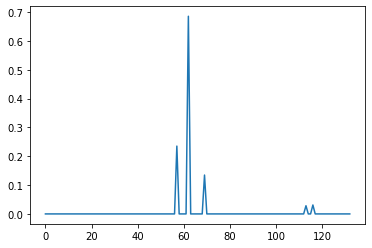

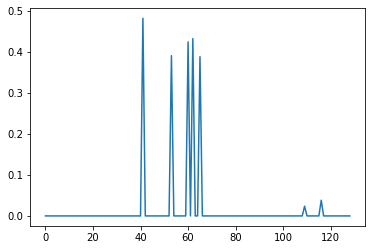

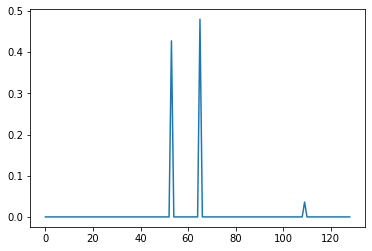

In [35]:
maj3 = []
min3 = []
maj5 = []
majchord = []
fbins = np.asarray(fbins)
favg = fbins[fbins > 0].max()
for i in range(len(fbins)-4):
    maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
for i in range(len(fbins)-3):
    min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
for i in range(len(fbins)-7):
    maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
    majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


maj3 = np.asarray(maj3)
min3 = np.asarray(min3)
maj5 = np.asarray(maj5)
majchord = np.asarray(majchord)
harmonicality  = len(maj3[np.log10(maj3+1e-12)>=-0.5]) + len(min3[np.log10(min3+1e-12)>=-0.5])+len(maj5[np.log10(maj5+1e-12)>=-0.5])+len(majchord[np.log10(majchord+1e-12)>=-0.5])
print("there are ",len(maj3[np.log10(maj3+1e-12)>=-0.5])," major third(s), ",
      len(min3[np.log10(min3+1e-12)>=-0.5])," minor third(s), ",
      len(maj5[np.log10(maj5+1e-12)>=-0.5])," major third(s), and ",
      len(majchord[np.log10(majchord+1e-12)>=-0.5])," major chord(s).")

plt.figure()
plt.plot((np.asarray(maj3) +1e-9))
plt.figure()
plt.plot((np.asarray(min3) +1e-9))
plt.figure()
plt.plot((np.asarray(maj5) +1e-9))
plt.figure()
plt.plot((np.asarray(majchord) +1e-9))

We also want to recognize the percussive hits. This is easy enough to do using the librosa onset_strength function. We then use peak detection to generate the total number of percussive crashes in the soundwave.

percussive peaks are at  [311 645 651 657 664 669 677 713 753 786 808] for a total length of  11


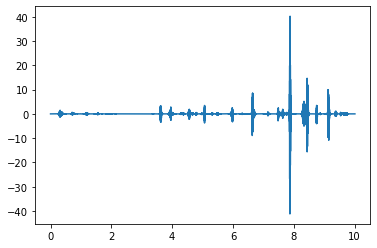

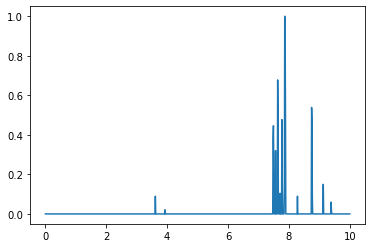

In [36]:
y_out = librosa.istft(y_percussive, length=len(test_y))
times = librosa.times_like(y_percussive)
plt.plot(dt*range(len(y_out)),y_out)
onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
#                                           hop_length=512,
                                         max_size=5,
                                          aggregate=np.median)
plt.figure()
plt.plot(times/2, onset_env / onset_env.max())
perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)
# onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
# onset_frames = librosa.onset.onset_detect(y = y_out, sr=sr)

print("percussive peaks are at ", perc_peaks, "for a total length of ", len(perc_peaks))

Make a function to do the cleanup and save the results as a nice, compact csv file.

We have iterated on the features a number of times, as can be seen by the commented out headers. In this version we include salience (whether the sound is background or foreground), as well as the power in the percussive and harmonic parts, and the number of percussive hits, and the time averaged number of harmonic chords.

In [37]:
def make_csv(filenm):
    file = open(filenm,'w+')
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,fold\n")
#     file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,thirds,fifths,fold\n")
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,musicality,fold\n")
    file.write("eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,harmonic_power,percussive_power,harmonic_hits,percussive_hits\n")


#     eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(1,131):
        ## load in the data
        y,sr = load_data(row_ind)
        ## no class or fold for this validation data
        
        ## get timing info
        t = np.round(librosa.get_duration(y=test_y,sr=sr),3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)

        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
        ## seperate into harmonic and percussive components
        D = librosa.stft(filt_y / filt_y.max())
        y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
        y_p = librosa.istft(y_percussive, length=len(filt_y))
        y_h = librosa.istft(y_harmonic, length=len(filt_y))
        Ptot = (filt_y**2).mean()
        ynorm = filt_y / np.sqrt(Ptot)
        Pnorm = (ynorm**2).mean()
        P_p = (y_p**2).mean()
        P_h = (y_h**2).mean()
        Anorm = np.sqrt(Pnorm/(P_h+P_p))
        y_p *= Anorm
        y_h *= Anorm
        
        y_percussive = librosa.stft(y_p)
        y_harmonic = librosa.stft(y_h)
        
        ## generate the MIDI range and corresponding frequencies
        st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
        fbins = []
        keypitch = []
        midi = []
        maxlen=np.size(y_harmonic,0)
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            keypitch.append(440*2**(p/12))
            midi.append(p+69)
            p += 1
            
        ## sum up the number of 3rds, 5ths, and chords
        harmonicality = 0
        for tm in range(np.size(y_harmonic,1)):
            p = -69
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)    
            while kmax <= 20000:
                kmin = 440*2**((p - 0.5)/12)
                kmax = 440*2**((p+0.5)/12)
                if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                    sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
                else:
                    sumbin = 0
                fbins.append(sumbin)
                p += 1

            peaks = librosa.util.localmax(np.asarray(fbins))

            maj3 = []
            min3 = []
            maj5 = []
            majchord = []
            fbins2 = np.asarray(fbins)
            if len(fbins2[fbins2 > 0] > 0):
                favg = fbins2[fbins2 > 0].max()
            else:
                favg = 1
            for i in range(len(fbins)-4):
                maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
            for i in range(len(fbins)-3):
                min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
            for i in range(len(fbins)-7):
                maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
                majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


            maj3 = np.asarray(maj3)
            min3 = np.asarray(min3)
            maj5 = np.asarray(maj5)
            majchord = np.asarray(majchord)
            maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
            min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
            maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
            majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
            harmonicality += maj3 + min3 + maj5 + majchord
        
        ## divide by the number of time slices to get mean harmonicality
        harmrate = harmonicality / np.size(y_harmonic,1)
        
        
        ## from the percussive component get the onsets for number of percussive hits
        y_out = librosa.istft(y_percussive, length=len(filt_y))

        onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                                 max_size=5,
                                                  aggregate=np.median)

        perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


        perc_rate = len(perc_peaks) #/ t
        
        ## generate equilizer values from fourier transform
        equilizer = np.zeros(len(eq_cutoffs))
        index = 0
        for i in range(len(equilizer)):
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(classifier)
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr))
        file.write(","+str(P_h))
        file.write(","+str(P_p))
        file.write(","+str(harmrate))
        file.write(","+str(perc_rate)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

In [38]:
make_csv('./large_data/futuramaValidation.csv')

KeyboardInterrupt: 

Check that everything worked and we can load our file as expected.

In [ ]:
eq_df = pd.read_csv('./large_data/futuramValidation.csv')
display(eq_df)

In [22]:
def make_eq_only_csv(filenm):
    file = open(filenm,'w+')
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,fold\n")
#     file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,thirds,fifths,fold\n")
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,musicality,fold\n")
    file.write("ind,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor\n")


#     eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(1,261):
        ## load in the data
        y,sr = load_data(row_ind)
        ## no class or fold for this validation data
        
        ## get timing info
        t = np.round(librosa.get_duration(y=test_y,sr=sr),3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)

        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
                
        ## generate equilizer values from fourier transform
        equilizer = np.zeros(len(eq_cutoffs))
        index = 0
        for i in range(len(equilizer)):
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(str(row_ind))
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

In [23]:
make_eq_only_csv('./large_data/futurama_eq_only.csv')

preprocessed audio file  1
preprocessed audio file  2
preprocessed audio file  3
preprocessed audio file  4
preprocessed audio file  5
preprocessed audio file  6
preprocessed audio file  7
preprocessed audio file  8
preprocessed audio file  9
preprocessed audio file  10
preprocessed audio file  11
preprocessed audio file  12
preprocessed audio file  13
preprocessed audio file  14
preprocessed audio file  15
preprocessed audio file  16
preprocessed audio file  17
preprocessed audio file  18
preprocessed audio file  19
preprocessed audio file  20
preprocessed audio file  21
preprocessed audio file  22
preprocessed audio file  23
preprocessed audio file  24
preprocessed audio file  25
preprocessed audio file  26
preprocessed audio file  27
preprocessed audio file  28
preprocessed audio file  29
preprocessed audio file  30
preprocessed audio file  31
preprocessed audio file  32
preprocessed audio file  33
preprocessed audio file  34
preprocessed audio file  35
preprocessed audio file  36
p

/var/folders/8b/9_w7wgkn0ksgvwhvvpcqjx2c0000gn/T/ipykernel_11188/403695295.py:50: RuntimeWarning: invalid value encountered in double_scalars
  equilizer[i] /= num


Also need to extract Paul's features

In [24]:
# Given time series y, gives ratio of points where y crosses xval vs total points. xval=0 gives Zero cross rate
def cross_rate(y, xval):  
    return np.sum(np.diff(y>xval))/len(y-1)

In [25]:
# Does a bunch of common stats like mean, median, etc
def desc_stat(y, name: str):  
    
    y_nanless = y[~np.isnan(y)]
    if len(y_nanless) == 0:
        return None
    
    if len(name)>0:
        name+='_'
    
    desc_stat = {}
    desc_stat[name+'mean'] = np.mean(y_nanless)
    desc_stat[name+'median'] = np.median(y_nanless)
    desc_stat[name+'std'] = np.std(y_nanless)
    desc_stat[name+'iqr'] = np.quantile(y_nanless,.75) - np.quantile(y_nanless,.25)  # Inter-quartile range
    desc_stat[name+'max'] = np.max(y_nanless)
    desc_stat[name+'min'] = np.min(y_nanless)
    return desc_stat

In [26]:
# For f being magnitude as function of frequency,
# find the total power in n_bands equally divided bands, then scale between 0 and 1
def power_bands_scaled(f, n_bands, logfreq=False):
    if logfreq:
        bands = np.logspace(0, np.log10(len(f)), n_bands+1)
    else:
        bands = np.linspace(0, len(f), n_bands+1)
    
    digitized = np.digitize(range(len(f)), bands)
    f_banded = [np.sum(f[digitized == i]) for i in range(1, len(bands))]
    f_banded_scaled = (f_banded-np.min(f_banded))/(np.max(f_banded)-np.min(f_banded))
    
    #plt.bar(range(1, len(bands)), f_banded_scaled)
    #plt.show()
    
    f_banded_scaled = {i:f_banded_scaled[i] for i in range(n_bands)}
    return f_banded_scaled

In [27]:
def engineer_features(row, *, n_fft, hop_length, freq_min, freq_max, rolling_length):
    features = {}
    
    # Load the data and obtain its STFT
    y, sr = load_data(row,sr=22050)
    y_stft_mag, y_stft_phase = librosa.magphase(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(y_stft_mag, ref=np.max) # Converting to decibell is effectively just a logarithmic transform
    
    # Cap the rolling window length if it's longer than the audio sample
    rolling_length = min(rolling_length,S_db.shape[1])
    
    # Note here we use 'power' (loosely) to refer to 'sum of log magnitudes'
    y_power = np.sum(S_db[freq_min:freq_max,:],axis=0)
    y_power_rolling = pd.Series(y_power).rolling(rolling_length, center=False).sum()
    
    # Finding the window with len=rolling_length that has maximum power
    best_window_ind = np.argmax(y_power_rolling) 
    y_window = y[(max(best_window_ind-rolling_length+1,0)*hop_length):((best_window_ind+1)*hop_length)]
    
    ### For the following features, 'mw' in the name means the feature was calculated in the maximum power window
    
    # Zero crossing rate
    features['y_mw_zcr'] = cross_rate(y_window,0)  # Zero crossing rate of the base signal in the max window
    
    # Mean power crossing rate
    S_db_window = S_db[:,max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    y_power_window = np.sum(S_db_window, axis=0)
    features['y_mw_power_mcr'] = cross_rate(y_power_window,np.median(y_power_window))
    
    spec_flatness = librosa.feature.spectral_flatness(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_flatness_window = spec_flatness[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_centroid = librosa.feature.spectral_centroid(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_centroid_window = spec_centroid[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_bandwidth_window = spec_bandwidth[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_rolloff_window = spec_rolloff[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
        
    features['spec_flatness'] = desc_stat(spec_flatness,'')
    features['spec_flatness_mw'] = desc_stat(spec_flatness_window,'')
    
    features['spec_centroid'] = desc_stat(spec_centroid,'')
    features['spec_centroid_mw'] = desc_stat(spec_centroid_window,'')

    features['spec_bandwidth'] = desc_stat(spec_bandwidth,'')
    features['spec_bandwidth_mw'] = desc_stat(spec_bandwidth_window,'')
    
    features['spec_rolloff'] = desc_stat(spec_rolloff,'')
    features['spec_rolloff_mw'] = desc_stat(spec_rolloff_window,'')
    
    freq_power_window = np.sum(S_db_window, axis=1)/rolling_length
    
    # Power in various frequency band divisions
    features['bands_mw_5'] = power_bands_scaled(freq_power_window,5)
    features['bands_mw_10'] = power_bands_scaled(freq_power_window,10)
    features['bands_mw_20'] = power_bands_scaled(freq_power_window,20)
    features['logbands_mw_5'] = power_bands_scaled(freq_power_window,5,logfreq=True)
    features['logbands_mw_10'] = power_bands_scaled(freq_power_window,10,logfreq=True)
    features['logbands_mw_20'] = power_bands_scaled(freq_power_window,20,logfreq=True)
    
    return features

In [31]:
%%time

# We use 3 sets of parameters for finding the max power window, though the only difference is the rolling length

stft_config_roll128 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 128 
}

stft_config_roll64 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 64 
}

stft_config_roll32 = {
    'n_fft' : 512, 
    'hop_length' : 512//4, 
    'freq_min' : 0,
    'freq_max' : 20000, 
    'rolling_length' : 32 
}


features = []

for i in range(1,261):
    if i % 10 == 0:
        print(i)
#     row = metadata.iloc[i]
    row = i
    row_features_roll32 = engineer_features(row, **stft_config_roll32)
    row_features_roll64 = engineer_features(row, **stft_config_roll64)
    row_features_roll128 = engineer_features(row, **stft_config_roll128)
    features.append({
        'roll_32':row_features_roll32,
        'roll_64':row_features_roll64,
        'roll_128':row_features_roll128
    })



10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
CPU times: user 2min 31s, sys: 2.55 s, total: 2min 34s
Wall time: 2min 36s


In [36]:
features_df = pd.json_normalize(features)
display(features_df)

,roll_32.y_mw_zcr,roll_32.y_mw_power_mcr,roll_32.spec_flatness.mean,roll_32.spec_flatness.median,roll_32.spec_flatness.std,roll_32.spec_flatness.iqr,roll_32.spec_flatness.max,roll_32.spec_flatness.min,roll_32.spec_flatness_mw.mean,roll_32.spec_flatness_mw.median,...,roll_128.logbands_mw_20.10,roll_128.logbands_mw_20.11,roll_128.logbands_mw_20.12,roll_128.logbands_mw_20.13,roll_128.logbands_mw_20.14,roll_128.logbands_mw_20.15,roll_128.logbands_mw_20.16,roll_128.logbands_mw_20.17,roll_128.logbands_mw_20.18,roll_128.logbands_mw_20.19
0,0.187988,0.18750,0.110579,0.077315,0.078758,0.154252,0.286432,0.001707,0.061139,0.060288,...,0.959840,0.953548,0.934274,0.900729,0.862285,0.812940,0.730737,0.598143,0.409162,0.0
1,0.236572,0.12500,0.065241,0.049744,0.050781,0.055699,0.287293,0.004611,0.127898,0.108588,...,0.961348,0.941681,0.911348,0.875964,0.831477,0.783590,0.703153,0.586626,0.408304,0.0
2,0.141846,0.18750,0.052653,0.042124,0.036894,0.039490,0.280403,0.004658,0.076398,0.069169,...,0.956872,0.947043,0.917274,0.890996,0.837766,0.787540,0.686259,0.553205,0.376001,0.0
3,0.200684,0.03125,0.063475,0.049740,0.066364,0.074929,0.383829,0.000014,0.105405,0.079570,...,0.962233,0.950943,0.928391,0.891245,0.851558,0.805795,0.721267,0.588290,0.399301,0.0
4,0.111084,0.25000,0.024763,0.006666,0.047126,0.016252,0.334248,0.000010,0.026774,0.023207,...,0.968700,0.961345,0.933297,0.898499,0.847763,0.790472,0.698572,0.551165,0.356246,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.231201,0.12500,0.058370,0.045046,0.047385,0.050871,0.281151,0.003117,0.126855,0.106695,...,0.957855,0.938336,0.906392,0.869745,0.823801,0.774577,0.691223,0.569857,0.389380,0.0
256,0.137451,0.09375,0.061247,0.049946,0.042161,0.049888,0.227789,0.003986,0.069071,0.064041,...,0.945964,0.938591,0.908594,0.870519,0.819776,0.753342,0.648698,0.517323,0.337252,0.0
257,0.146484,0.03125,0.061099,0.051719,0.039390,0.049177,0.249600,0.005316,0.072432,0.064497,...,0.954346,0.946547,0.918039,0.886105,0.837290,0.774226,0.666444,0.536784,0.353410,0.0
258,0.146729,0.09375,0.008001,0.000070,0.021853,0.003565,0.151883,0.000003,0.079478,0.075605,...,0.952426,0.942628,0.923773,0.883803,0.830779,0.773740,0.677256,0.557054,0.372081,0.0


In [37]:
features_df.to_csv('large_data/futurama_engineered_features_full1.csv')

In [ ]:
# Keys for classifier 

full_classify_keys = [
 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000',
 'crestfactor',
 #'salience', # We don't include this because it isn't in anything we can test on
 'harmonic_power',
 'percussive_power',
 'harmonic_hits',
 'percussive_hits',
 'power_ratio',
 'hits_ratio',
 'roll_32.spec_flatness.median',
 'roll_32.spec_flatness.iqr',
 'roll_32.spec_centroid.median',
 'roll_32.spec_bandwidth.median',
 'roll_32.spec_bandwidth.std',
 'roll_32.y_mw_zcr',
 'roll_64.spec_flatness.median',
 'roll_64.spec_flatness.iqr',
 'roll_64.spec_centroid.median',
 'roll_64.spec_bandwidth.median',
 'roll_64.spec_bandwidth.std',
 'roll_64.y_mw_zcr',
 'roll_128.spec_flatness.median',
 'roll_128.spec_flatness.iqr',
 'roll_128.spec_centroid.median',
 'roll_128.spec_bandwidth.median',
 'roll_128.spec_bandwidth.std',
 'roll_128.y_mw_zcr',
 'roll_64.logbands_mw_5.0',
 'roll_64.logbands_mw_5.1',
 'roll_64.logbands_mw_5.2',
 'roll_64.logbands_mw_5.3',
 'roll_64.logbands_mw_5.4',
 'roll_64.logbands_mw_10.0',
 'roll_64.logbands_mw_10.1',
 'roll_64.logbands_mw_10.2',
 'roll_64.logbands_mw_10.3',
 'roll_64.logbands_mw_10.4',
 'roll_64.logbands_mw_10.5',
 'roll_64.logbands_mw_10.6',
 'roll_64.logbands_mw_10.7',
 'roll_64.logbands_mw_10.8',
 'roll_64.logbands_mw_10.9',
 'roll_64.logbands_mw_20.0',
 'roll_64.logbands_mw_20.1',
 'roll_64.logbands_mw_20.2',
 'roll_64.logbands_mw_20.3',
 'roll_64.logbands_mw_20.4',
 'roll_64.logbands_mw_20.5',
 'roll_64.logbands_mw_20.6',
 'roll_64.logbands_mw_20.7',
 'roll_64.logbands_mw_20.8',
 'roll_64.logbands_mw_20.9',
 'roll_64.logbands_mw_20.10',
 'roll_64.logbands_mw_20.11',
 'roll_64.logbands_mw_20.12',
 'roll_64.logbands_mw_20.13',
 'roll_64.logbands_mw_20.14',
 'roll_64.logbands_mw_20.15',
 'roll_64.logbands_mw_20.16',
 'roll_64.logbands_mw_20.17',
 'roll_64.logbands_mw_20.18',
 'roll_64.logbands_mw_20.19']